<a href="https://colab.research.google.com/github/esthermead/deeplearning/blob/master/Crowd_Counting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# from https://www.analyticsvidhya.com/blog/2019/02/building-crowd-counting-model-python/
# WARNING!!!! if you leave this and it times out, you will have to START OVER bcz it doesn't save anything!!!!!
# WARNING!!!! starting over takes an INSANE AMOUNT OF TIME! not worth it, so STAY WITH IT!

In [2]:
# click Runtime, select "change runtime", choose "GPU" accelaration.
# mount drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [4]:
# change working directory to my DeepLearning folder
cd "/content/drive/My Drive/DeepLearning/CSRNet-pytorch"

/content/drive/My Drive/DeepLearning/CSRNet-pytorch


In [5]:
pwd

u'/content/drive/My Drive/DeepLearning/CSRNet-pytorch'

In [0]:
# clone the github for this tutorial
# !git clone https://github.com/leeyeehoo/CSRNet-pytorch.git errors with this one bcz for python2
# try replacing with this one supposedly for p3
#!git clone https://github.com/vivek-bombatkar/CSRNet-pytorch.git

Cloning into 'CSRNet-pytorch'...
remote: Enumerating objects: 101, done.
remote: Total 101 (delta 0), reused 0 (delta 0), pack-reused 101
Receiving objects: 100% (101/101), 626.39 KiB | 1.65 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [0]:
# BEGIN enter code from the "make_dataset.ipynb" so that I can have all here in one notebook.
# started to do this but error stopped me dead in my tracks "ImportError: No module named model"
# going to try running it from the "make_dataset.ipynb" instead. going back to original idea bcz i figured out i was in wrong directory.

In [0]:
# importing libraries
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import scipy
import json
from matplotlib import cm as CM
from image import *
from model import CSRNet
import torch
from tqdm import tqdm
%matplotlib inline

In [0]:
# function to create density maps for images
# code on tut is wrong; copy from "make_dataset.ipynb" instead
#this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet
def gaussian_filter_density(gt):
    print gt.shape
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(zip(np.nonzero(gt)[1], np.nonzero(gt)[0]))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print 'generate density...'
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print 'done.'
    return density

In [5]:
pwd

u'/content/drive/My Drive/DeepLearning/CSRNet-pytorch'

In [0]:
#set the root to the Shanghai dataset you download
root = '/content/drive/My Drive/DeepLearning/CSRNet-pytorch/'

In [0]:
#now generate the ShanghaiA's ground truth
#had to change these paths
part_A_train = os.path.join(root,'ShanghaiTech/part_A/train_data','images')
part_A_test = os.path.join(root,'ShanghaiTech/part_A/test_data','images')
part_B_train = os.path.join(root,'ShanghaiTech/part_B/train_data','images')
part_B_test = os.path.join(root,'ShanghaiTech/part_B/test_data','images')
path_sets = [part_A_train,part_A_test]

In [0]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [30]:
for img_path in img_paths:
    print (img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground-truth'), 'w') as hf:
            hf['density'] = k

/content/drive/My Drive/DeepLearning/CSRNet-pytorch/ShanghaiTech/part_A/train_data/images/IMG_1.jpg
(768, 1024)
generate density...
done.
/content/drive/My Drive/DeepLearning/CSRNet-pytorch/ShanghaiTech/part_A/train_data/images/IMG_10.jpg
(683, 1024)
generate density...
done.
/content/drive/My Drive/DeepLearning/CSRNet-pytorch/ShanghaiTech/part_A/train_data/images/IMG_100.jpg
(654, 1024)
generate density...
done.
/content/drive/My Drive/DeepLearning/CSRNet-pytorch/ShanghaiTech/part_A/train_data/images/IMG_101.jpg
(768, 1024)
generate density...
done.
/content/drive/My Drive/DeepLearning/CSRNet-pytorch/ShanghaiTech/part_A/train_data/images/IMG_102.jpg
(768, 1024)
generate density...
done.
/content/drive/My Drive/DeepLearning/CSRNet-pytorch/ShanghaiTech/part_A/train_data/images/IMG_103.jpg
(400, 400)
generate density...
done.
/content/drive/My Drive/DeepLearning/CSRNet-pytorch/ShanghaiTech/part_A/train_data/images/IMG_104.jpg
(405, 540)
generate density...
done.
/content/drive/My Drive/D

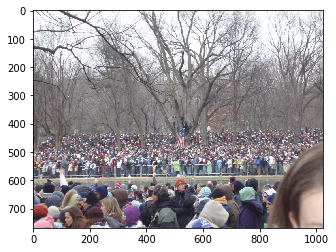

In [12]:
#now see a sample from ShanghaiA
plt.imshow(Image.open(img_paths[0]))

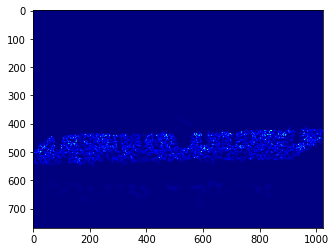

In [13]:
gt_file = h5py.File(img_paths[0].replace('.jpg','.h5').replace('images','ground-truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [14]:
np.sum(groundtruth)

1543.841

In [35]:
path_sets = [part_B_train,part_B_test]
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)
        
# creating density map for part_b images

for img_path in img_paths:
    print (img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground-truth'), 'w') as hf:
            hf['density'] = k

/content/drive/My Drive/DeepLearning/CSRNet-pytorch/ShanghaiTech/part_B/train_data/images/IMG_1.jpg
(768, 1024)
generate density...
done.
/content/drive/My Drive/DeepLearning/CSRNet-pytorch/ShanghaiTech/part_B/train_data/images/IMG_10.jpg
(768, 1024)
generate density...
done.
/content/drive/My Drive/DeepLearning/CSRNet-pytorch/ShanghaiTech/part_B/train_data/images/IMG_100.jpg
(768, 1024)
generate density...
done.
/content/drive/My Drive/DeepLearning/CSRNet-pytorch/ShanghaiTech/part_B/train_data/images/IMG_101.jpg
(768, 1024)
generate density...
done.
/content/drive/My Drive/DeepLearning/CSRNet-pytorch/ShanghaiTech/part_B/train_data/images/IMG_102.jpg
(768, 1024)
generate density...
done.
/content/drive/My Drive/DeepLearning/CSRNet-pytorch/ShanghaiTech/part_B/train_data/images/IMG_103.jpg
(768, 1024)
generate density...
done.
/content/drive/My Drive/DeepLearning/CSRNet-pytorch/ShanghaiTech/part_B/train_data/images/IMG_104.jpg
(768, 1024)
generate density...
done.
/content/drive/My Drive

In [15]:
pwd

u'/content/drive/My Drive/DeepLearning/CSRNet-pytorch'

In [2]:
# this is set to epochs = 400 in the train.py so it will take an insane amount of time and will experience several timeouts in google colab.
# when try with my own images, remember to go in and reduce epochs in the train.py
# for tut purposes use the pretrained weights .tar that i DLed and put in directory already.
!python train.py part_A_train.json part_A_val.json 0 0

python2: can't open file 'train.py': [Errno 2] No such file or directory


In [0]:
#importing libraries
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import scipy
import json
import torchvision.transforms.functional as F
from matplotlib import cm as CM
from image import *
from model import CSRNet
import torch
%matplotlib inline

In [0]:
from torchvision import datasets, transforms
transform=transforms.Compose([
                      transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]),
                  ])

In [0]:
#defining the location of dataset
#these directories were edited to match mine (current user)
root = '/content/drive/My Drive/DeepLearning/CSRNet-pytorch'
part_A_train = os.path.join(root,'ShanghaiTech/part_A/train_data','images')
part_A_test = os.path.join(root,'ShanghaiTech/part_A/test_data','images')
part_B_train = os.path.join(root,'ShanghaiTech/part_B/train_data','images')
part_B_test = os.path.join(root,'ShanghaiTech/part_B/test_data','images')
path_sets = [part_A_test]

In [0]:
#defining the image path
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
       img_paths.append(img_path)

In [20]:
model = CSRNet()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
553433881it [00:04, 114525301.98it/s]


In [0]:
#defining the model
model = model.cuda()

In [0]:
#loading the trained weights
checkpoint = torch.load('ShanghaiTech/part_A/0model_best.pth.tar')
model.load_state_dict(checkpoint['state_dict'])

In [25]:
#checking the Mean Absolute Error (MAE) on test images to evaluate the model.
#notice the output says 75.697 (which the tut says is "pretty good".)
mae = 0
for i in tqdm(range(len(img_paths))):
    img = transform(Image.open(img_paths[i]).convert('RGB')).cuda()
    gt_file = h5py.File(img_paths[i].replace('.jpg','.h5').replace('images','ground-truth'),'r')
    groundtruth = np.asarray(gt_file['density'])
    output = model(img.unsqueeze(0))
    mae += abs(output.detach().cpu().sum().numpy()-np.sum(groundtruth))
print (mae/len(img_paths))

100%|██████████| 182/182 [05:16<00:00,  1.46s/it]

75.69745107797476


('Predicted Count : ', 384)


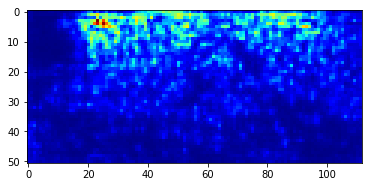

('Original Count : ', 382)


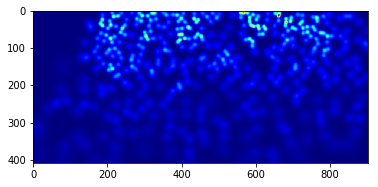

Original Image


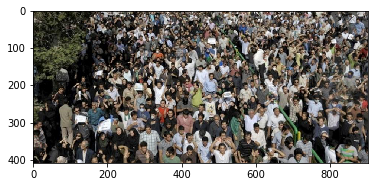

In [26]:
#now check the predictions on a single image.
#have to change paths to match your directory.
from matplotlib import cm as c
img = transform(Image.open('ShanghaiTech/part_A/test_data/images/IMG_100.jpg').convert('RGB')).cuda()

output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()
temp = h5py.File('ShanghaiTech/part_A/test_data/ground-truth/IMG_100.h5', 'r')
temp_1 = np.asarray(temp['density'])
plt.imshow(temp_1,cmap = c.jet)
print("Original Count : ",int(np.sum(temp_1)) + 1)
plt.show()
print("Original Image")
plt.imshow(plt.imread('ShanghaiTech/part_A/test_data/images/IMG_100.jpg'))
plt.show()

#notice in output that original image people count was 382, and the model predicted 384! Very cool!

In [0]:
#reminder of tutorial URLs used:
# https://www.analyticsvidhya.com/blog/2019/02/building-crowd-counting-model-python/
# https://github.com/vivek-bombatkar/CSRNet-pytorch
# https://github.com/leeyeehoo/CSRNet-pytorch